# Solve the Heat equation.

A very know PDE is the heat equation. It's a very importan equation that describes the distribution of heat in a structure or space in a certain time.


The PDE looks like this:

\begin{equation}
\frac{\partial T}{\partial t}=\alpha\frac{\partial^2T}{\partial x^2}+f(T)
\end{equation}

where $T$ is the temperature of the system, $\alpha$ is the thermal diffusion constant and $f(T)$ is a function that apply to our system.

In this case, i'm gonna simulate the temperature of a long bar in 1D. The bar had the following boundary conditions:

\begin{equation}
\frac{\partial T_0}{\partial x}=\frac{\partial T_L}{\partial x}=0
\end{equation}

The bar has a large of $L=70cm$, where the initial conditions are:

\begin{equation}
T^0=\hspace{3mm}\left\{\begin{array}{cc}
400K & 0cm\leq x\leq 10cm \\
10K & 10cm<x<30cm \\
100K & 30cm\leq x\leq 40cm\\
10K & 40cm<x<60cm\\
400K & 60cm\leq x\leq70cm
\end{array}
\right.\end{equation}

I'm going to solve the system for $t_F=30$ minutes. The $\alpha$ constant had a value of $0.01$.

In [1]:
import numpy as np
from numba import njit
from matplotlib.animation import FuncAnimation
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

## Explicit Method

In this method, i'm gonna solve the equations using a discretized version of the derivates. That is

\begin{equation}
\Large\begin{array}{cc}
\frac{\partial T}{\partial t}\approx \frac{T_x^{t+1}-T_x^t}{\Delta t} &
\frac{\partial^2 T}{\partial x^2}\approx \frac{T_{x+1}^t-2T_{x}^t+T_{x-1}^t}{\Delta x^2}
\end{array}
\end{equation}

Using this in our PDE, i had

\begin{equation}
\frac{T_x^{t+1}-T_x^t}{\Delta t}=\alpha\frac{T_{x+1}^t-2T_{x}^t+T_{x-1}^t}{\Delta x^2}+f(T)
\end{equation}

Using algebra, i had

\begin{equation}

T_x^{t+1}=T_x^t+k\left(T_{x+1}^t-2T_{x}^t+T_{x-1}^t+\frac{\Delta x^2}{\alpha} f(T)\right)
\end{equation}

where $k=\alpha\frac{\Delta t}{\Delta x^2}$. Using more algebra, i had

\begin{equation}
T_x^{t+1}=(1-2k)T_x^t+k\left(T_{x+1}^t+T_{x-1}^t+\frac{\Delta x^2}{\alpha} f(T)\right)
\end{equation}

And that's all! Now, we only had to discretized our Neumman Boundary Conditions. That is:

\begin{equation}
\large\begin{array}{cc}
\frac{\partial T_0}{\partial x}\approx\frac{T_{0}^t-T_{-1}^t}{\Delta x} &
\frac{\partial T_L}{\partial x}\approx\frac{T_{L+1}^t-T_{L}^t}{\Delta x} \\

\frac{T_{0}^t-T_{-1}^t}{\Delta x}=0 & \frac{T_{L+1}^t-T_{L}^t}{\Delta x}=0 \\
T_0^t=T_{-1}^t & T_{L+1}^t=T_{L}^t


\end{array}
\end{equation}

That leave me the following equations to calculate $T_0$ and $T_L$

\begin{equation}
\begin{array}{c}
T_0^{t+1}=(1-3k)T_0^t+k\left(T_{1}^t+\frac{\Delta x^2}{\alpha} f(T)\right) \\
T_L^{t+1}=(1-3k)T_L^t+k\left(T_{L-1}^t+\frac{\Delta x^2}{\alpha} f(T)\right)

\end{array}
\end{equation}

Now, I can write the functions to solve this problem.

In [6]:
@njit()
def explicit(heat_0,Nx,Nt,k,dx,alpha):
    T=IC(heat_0,Nx,Nt)
    T=BC(T,0,Nx,k,dx,alpha)
    for j in range(0,Nt-1):
        for i in range(0,Nx-1):
            T[i,j+1]=(1-2*k)*T[i,j]+k*(T[i+1,j]+T[i-1,j]+(dx**2/alpha)*f(Nt))
        T=BC(T,j,Nx,k,dx,alpha)
    return T

@njit()
def IC(heat_0,Nx,Nt):
    T=np.zeros((Nx,Nt))
    for i in range(Nx):
        T[i,0]=heat_0[i]
    return T

@njit()
def BC(T,j,Nx,k,dx,alpha):
    T[0,j+1]=(1-k)*T[0,j]+k*(T[1,j]+(dx**2/alpha)*f(Nt))
    T[Nx-1,j+1]=(1-k)*T[Nx-1,j]+k*(T[Nx-2,j]+(dx**2/alpha)*f(Nt))
    return T

Using a $f(T)=0$. I can solve the system now.

In [3]:
@njit
def f(Nt):
    return 0

#Values
tf=1800
L=70
alpha=0.01
#Grid points
Nx=101
Nt=101
#Arrays
t=np.linspace(0,tf,Nt)
x=np.linspace(0,L,Nx)
#Make dt and dx
dt=tf/(Nt-1)
dx=L/(Nx-1)

#Create the array for the initial condition
heat_0=np.zeros(Nx)
for i in range(Nx):
    if (x[i]<=10):
        heat_0[i]=400
    elif (10<x[i]<30):
        heat_0[i]=10
    elif (30<=x[i]<=40):
        heat_0[i]=100
    elif (40<x[i]<60):
        heat_0[i]=10
    else:
        heat_0[i]=400

#Check k
k=alpha*(dt/dx**2)
print('The value of the CFL constant is k={0:.4f}'.format(k))

The value of the CFL constant is k=0.3673


We can see tht with only 101 grid points for $t$, our CFL constant is $k=0.3673$. 

Like is the heat equation, we need a $k<0.5$ if we want it stable. In this case, it's good.

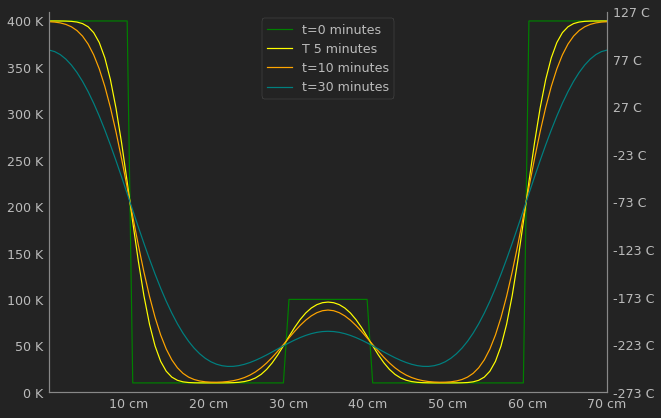

In [8]:
#Solve the equation
T=explicit(heat_0,Nx,Nt,k,dx,alpha)

def plot(x,t,T,Nx,Nt):
    #Array for labels
    xlabel=np.linspace(10,70,7)
    ylabel=np.linspace(0,T.max(),9)
    #Plot
    fig,axs=plt.subplots(1,figsize=(10,7))
    axs.plot(x,T[:,0],color='green',label='t=0 minutes')
    for j in range(0,Nt-1):
        if (5*60-10<t[j]<5*60+10):
            axs.plot(x,T[:,j],color='yellow',label='T 5 minutes')
        elif (10*60-10<t[j]<10*60+10):
            axs.plot(x,T[:,j],color='orange',label='t=10 minutes')
        elif (20*60+10<t[j]<20*60+10):
            axs.plot(x,T[:,j],color='red',label='t=20 minutes')
    axs.plot(x,T[:,Nt-1],color='teal',label='t=30 minutes')
    axs.set_xlim(x[0],x[Nx-1])
    axs.set_ylim(0,T.max()+10)
    axs.spines['top'].set_visible(False)
    axs.set_xticks(xlabel)
    axs.set_xticklabels(['{0:.0f} cm'.format(xlabel[i]) for i in range(len(xlabel))])
    axs.set_yticks(ylabel)
    axs.set_yticklabels(['{0:.0f} K'.format(ylabel[i]) for i in range(len(ylabel))])
    ax2=axs.twinx()
    ax2.set_yticks([ylabel[i]-273.13 for i in range(len(ylabel))])
    ax2.set_yticklabels(['{0:.0f} C'.format(ylabel[i]-273.13) 
    for i in range(len(ylabel))])
    ax2.spines['top'].set_visible(False)
    axs.legend()
    axs.grid(False)
    ax2.grid(False)
    plt.show()

plot(x,t,T,Nx,Nt)

In [192]:
#Animate

#Make the animation
def animate_plot(T,x,t,Nx,Nt): 
    #Array for labels
    xlabel=np.linspace(10,70,7)
    ylabel=np.linspace(0,T.max(),9)
    #Plot
    fig, axs=plt.subplots(1,figsize=(10,7))
    line,=axs.plot([],[],color='orange')
    axs.set_xlim(x[0],x[Nx-1])
    axs.set_ylim(0,T.max()+10)
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.set_xticks(xlabel)
    axs.set_xticklabels(['{0:.0f} cm'.format(xlabel[i]) for i in range(len(xlabel))])
    axs.set_yticks(ylabel)
    axs.set_yticklabels(['{0:.0f} K'.format(ylabel[i]) for i in range(len(ylabel))])
    ax2=axs.twinx()
    ax2.set_yticks([ylabel[i]-273.13 for i in range(len(ylabel))])
    ax2.set_yticklabels(['{0:.0f} C'.format(ylabel[i]-273.13) 
        for i in range(len(ylabel))])
    ax2.spines['top'].set_visible(False)
    axs.grid(False)
    ax2.grid(False)
    return line,fig,axs

def init():
    line,=axs.plot([],[],color='orange')
    return line,

def animate(i):
    global x,T,t,Nx
    axs.collections.clear()
    line.set_data(x,T[:,i])
    points=axs.scatter([x[j] for j in range(0,Nx,3)],[T[j,i] for j in range(0,Nx,3)],color='orange')
    axs.set_title('Temperature profile in t={0:.2f} minutes'.format(t[i]/60))
    fill= axs.fill_between(x,T[:,i],0, color='orange',alpha=0.2)
    return line, fill, points

line,fig,axs=animate_plot(T,x,t,Nx,Nt)

anim=FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Temperature_profile.mp4',fps=20,extra_args=['-vcodec','libx264'])

CPU times: user 11 s, sys: 455 ms, total: 11.5 s
Wall time: 12.2 s


If we want to simulate more time, like $60$ minutes, we can use more grid points to make it stable.

In [193]:
Nt=301
tf=1*3600
#Arrays
t=np.linspace(0,tf,Nt)
#Make dt and dx
dt=tf/(Nt-1)

#Check k
k=alpha*(dt/dx**2)
print('The value of the CFL constant is k={0:.4f}'.format(k))

T=explicit(heat_0,Nx,Nt,k,dx,alpha)

line,fig,axs=animate_plot(T,x,t,Nx,Nt)

anim=FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Temperature_profile2.mp4',fps=20,extra_args=['-vcodec','libx264'])

The value of the CFL constant is k=0.2449
CPU times: user 33.6 s, sys: 1.59 s, total: 35.2 s
Wall time: 36.9 s


It's a great way to compute large simulations, but if we use more grid points that mean that we need to use more memory to solve the equation.

## Implicit method

Exist other scheme that I can use to compute the PDE. This scheme is called **Implicit* and it's numerically stable so we don't need a $k<0.5$ to sure the stability of the system. 

In this method, we can use the following discretization for the derivates

\begin{equation}
\Large\begin{array}{cc}
\frac{\partial T}{\partial t}\approx \frac{T_x^{t+1}-T_x^t}{\Delta t} &
\frac{\partial^2 T}{\partial x^2}\approx \frac{T_{x+1}^{t+1}-2T_{x}^{t+1}+T_{x-1}^{t+1}}{\Delta x^2}
\end{array}
\end{equation}

So, with this discretization, our PDE is

\begin{equation}
\frac{T_x^{t+1}-T_x^t}{\Delta t}=\alpha\frac{T_{x+1}^{t+1}-2T_{x}^{t+1}+T_{x-1}^{t+1}}{\Delta x^2}+f(T)
\end{equation}

Using algebra, I had

\begin{equation}
T_{x}^{t}=(1+2k)T_x^{t+1}-k(T_{x+1}^{t+1}+T_{x-1}^{t+1}+\Delta x^2f(T))
\end{equation}

We can express this system as a matrix. I can express the system as

\begin{equation}

T_{x}^{t}=-kT_{x+1}^{t+1}+(1+2k)T_x^{t+1}-kT_{x-1}^{t+1}-k\frac{\Delta x^2}{\alpha}f(T)

\end{equation}

I can express this as a matrix. The system it's gonna be

\begin{equation}
AT_x^{t+1}-k\frac{\Delta x^2}{\alpha}f(T)=b
\end{equation}

Where $b=(T_0^{t},T_1^{t},T_3^{t},\cdots,T_x^t)$ while A is

\begin{equation}
\begin{array}{c}
A(i,i-1)=-k \\
A(i,i)=1+2k \\
A(i.i+1)=-k
\end{array}
\end{equation}

Where $A(0,0)=A(x,x)=1$, this to get a stable tridiagonal matrix. So, our final expresion is:

\begin{equation}
    \begin{bmatrix}
    A_{0,0} & A_{0,1} & & & 0 \\
    A_{1,0} & A_{1,1} & A_{1,2} & &  \\
    & A_{2,1} & A_{2,2} & \ddots & \\
    & & \ddots & \ddots & A_{x-1,x} \\
    0 & & & A_{x,x-1} & A_{x,x}
    \end{bmatrix} 
    \left.
    \begin{bmatrix}
    T_1^{t+1} \\
    T_2^{t+1} \\
    T_3^{t+1} \\
    \vdots \\
    T_x^{t+1}
    \end{bmatrix}
    \right. -k\frac{\Delta x^2}{\alpha}f(T)
    =\begin{bmatrix}
    T_1^{t} \\
    T_2^{t} \\
    T_3^{t} \\
    \vdots \\
    T_x^{t}
    \end{bmatrix}
\end{equation}

With this, I can code the PDE.

In [9]:
#Function to create the matrix A
@njit
def matrixA(Nx,k):
    A=np.zeros((Nx,Nx))
    #Loop to calculate the values of A
    for i in range(1,Nx-1):
        A[i,i-1]=-k
        A[i,i]=1+2*k
        A[i,i+1]=-k
    #Boundary conditions for the matrix A
    A[0,0]=1
    A[Nx-1,Nx-1]=1
    return A

#Function to solve the system A*T=b
@njit
def solution(T,A):
    #Create the matrix b with the current values
    b=T.copy()

    #Use a command of numpy to solve A*T=b
    T=np.linalg.solve(A,b)

    return T

#function to solve all the equation
@njit
def implicit(heat_0,Nx,Nt,k,dx,alpha):
    #Create the matrix solution T and add some values
    T=IC(heat_0,Nx,Nt)
    T=BC(T,0,Nx,k,dx,alpha)
    #Now, call the function to create the matrix A
    A=matrixA(Nx,k)
    #Now, the loop to get the solution
    for j in range(0,Nt-1):
        T[:,j+1]=solution(T[:,j],A)-k*(dx**2/alpha)*f(Nt)
        #Get sure that the BC still exist
        T=BC(T,j,Nx,k,dx,alpha)
    return T

Now, using the original values for the system, I can call the function implicit and look the results.

The value of the CFL constant is k=0.3673
CPU times: user 7.32 s, sys: 1.32 s, total: 8.65 s
Wall time: 6.64 s


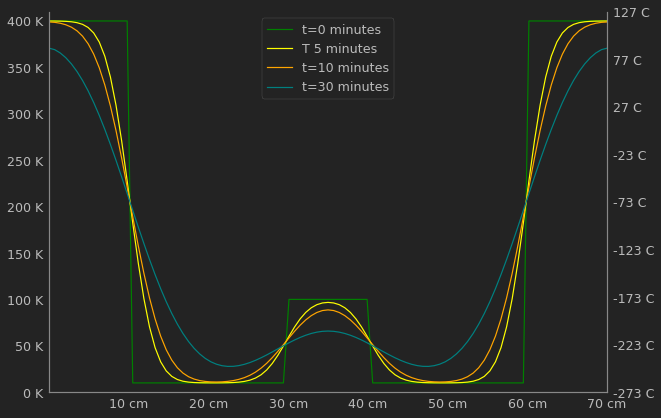

In [10]:
#Use one more time the original values
#Values
tf=1800
L=70
alpha=0.01
#Grid points
Nx=101
Nt=101
#Arrays
t=np.linspace(0,tf,Nt)
x=np.linspace(0,L,Nx)
#Make dt and dx
dt=tf/(Nt-1)
dx=L/(Nx-1)

#Check k
k=alpha*(dt/dx**2)
print('The value of the CFL constant is k={0:.4f}'.format(k))

#Call the function and save the solution in a matrix T
%time T=implicit(heat_0,Nx,Nt,k,dx,alpha)

#Now, plot the results.
plot(x,t,T,Nx,Nt)

It works! It's no more faster that the Explicit Method, but it's more stable and accurate. If we want to simulate 60 minutes, we just need to update our values $k$.

In [196]:
Nt=101
tf=1*3600
#Arrays
t=np.linspace(0,tf,Nt)
#Make dt and dx
dt=tf/(Nt-1)

#Check k
k=alpha*(dt/dx**2)
print('The value of the CFL constant is k={0:.4f}'.format(k))

#Call the function and save the matrix solution in T
T=implicit(heat_0,Nx,Nt,k,dx,alpha)

line,fig,axs=animate_plot(T,x,t,Nx,Nt)

anim=FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Temperature_profile3.mp4',fps=20)

The value of the CFL constant is k=0.7347
CPU times: user 10.5 s, sys: 614 ms, total: 11.1 s
Wall time: 11.7 s


The video goes faster that the done with the explicit method, the reason is really simple.

When I simulate the 60 minutes with the explicit method, I have to use more grid points ($N_t$=301). But with the implicit method, i can use only the first $N_t=101$ grid points and takes less moments to simulate. So, when I create the video, with the explicit method I have more frames per video, when with the implicit i have less frames per video.

For example, I want to simulate 2 hours of the system (120 minutes), I would need a minimun of $N_t=295$ but with the implicit I only need $N_t=101$. Let have a look

In [197]:
Nt=101
tf=2*3600
#Arrays
t=np.linspace(0,tf,Nt)
#Make dt and dx
dt=tf/(Nt-1)

#Check k
k=alpha*(dt/dx**2)
print('The value of the CFL constant is k={0:.4f}'.format(k))

#Call the function and save the matrix solution in T
T=implicit(heat_0,Nx,Nt,k,dx,alpha)

#Call the function to create the animate system.
line,fig,axs=animate_plot(T,x,t,Nx,Nt)


anim=FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Temperature_profile4.mp4',fps=20)

The value of the CFL constant is k=1.4694
CPU times: user 11.3 s, sys: 900 ms, total: 12.2 s
Wall time: 13.3 s


And now, we can play with this model! For example, suppose that the extrems of my bar are attached to a heater. In the middle, the bar has a cooler. This system is

\begin{equation}
T=\hspace{3mm}\left\{\begin{array}{cc}
400K & 0cm\leq x\leq 10cm \\
100K & 30cm\leq x\leq 40cm\\
400K & 60cm\leq x\leq70cm
\end{array}
\right.\text{for every t.}\end{equation}

For this, i just need to create the next function

In [201]:
@njit()
def gradient(T,j,heat_0):
    for i in range(Nx):
        if (heat_0[i]>10):
            T[i,j]=heat_0[i]
    return T

Also, i need to modify one of the Python function to solve the system. I choose the implicit method.

In [202]:
@njit()
def implicit_gradient(heat_0,Nx,Nt,k,dx,alpha):
    #Create the matrix solution T and add some values
    T=IC(heat_0,Nx,Nt)
    #Now, call the function to create the matrix A
    A=matrixA(Nx,k)
    #Now, the loop to get the solution
    for j in range(0,Nt-1):
        T[:,j+1]=solution(T[:,j],A)-k*(dx**2/alpha)*f()
        #Use the funtion to plot the others results
        T=gradient(T,j+1,heat_0)
    return T

Now you can check the result!

In [204]:
#Call the function and save the solution in a matrix T
T=implicit_gradient(heat_0,Nx,Nt,k,dx,alpha)

#Now, plot the results.
#Call the function to create the animate system.
line,fig,axs=animate_plot(T,x,t,Nx,Nt)


anim=FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Temperature_profile5.mp4',fps=20)

CPU times: user 179 ms, sys: 92.2 ms, total: 272 ms
Wall time: 101 ms
CPU times: user 13.5 s, sys: 687 ms, total: 14.2 s
Wall time: 15.3 s
